## Practical exercises. Part III

### Andrey Kravtsov

### The University of Chicago 

### email: kravtsov@uchicago.edu

Exercises in this Part III of the practical exercises related to galaxy formation explore the simple galaxy formation model discussed in lectures. Different versions of the model are implemented using python classes in the file <a href="codes/galaxy_model.py">codes/galaxy_model.py</a>. I encourage you to explore it and map particular routines to equations and physical processes in notebooks of structure formation <a href="l04_peak_profile_MAH.ipynb">lecture 4</a> and <a href="l05_galaxy_formation.ipynb">lecture 5.</a>

A specific exercise I suggest below is exploration of predictions of different versions of the model (that include different processes) and comparison of their predictions for the relation between abundance of heavy elements ("metallicity") of galaxies and stellar mass galaxies that is well established for nearby dwarf galaxies. 

In [4]:
# boiler plate auxiliary stuff
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from codes.plot_utils import plot_pretty
plot_pretty()

### Context. 

A simple galaxy formation model was introduced in lecture 4. In lecture 5 different processes that affect galaxy formation were discussed and these were included in the model in a parameterized form. Effect of different processes on $M_\star-M_{\rm halo}$ relation was examined, but we have not looked at any other predictions of the model. 

In this exercise we will look what different versions of the model predict for the relation between galaxy metallicity and its stellar mass, which is now well established in the low-mass regime for galaxies. 

This is just to give you a tast of how testing and explorations of such models can occur. Successes and failures in such comparison teach us about what physical processes are relevant for different observable properties of galaxies and also constrain these processes. 

### Code running different models

Run models with different physical ingredients below. 

First set up cosmological model for the calculation of model galaxy evolution. 

In [1]:
from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.3, 'Ob0': 0.045714, 'sigma8': 0.81, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)    

The routine below computes model results on a 2d grid of initial halo masses and redshifts and constructs 2d interpolating spline table that can be used to plot model predictions smoothly. 

In [6]:
import codes.galaxy_model as gm

from scipy.interpolate import interp2d
from scipy.integrate import odeint

def compute_mass_grid(gmodel = None, Nz=81, Nm=60, kwargs=None):
    # grid of redshifts and halo masses
    zg = np.linspace(30., 0., Nz)
    lzg1 = np.log10(1.0+zg)
    t_output = cosmo.age(zg)
    
    lMh = np.linspace(5.0, 8., Nm)
    Mh  = np.power(10, lMh)

    # arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
    Mhout  = np.zeros((Nm,Nz)); Mgout  = np.zeros((Nm,Nz))
    Msout  = np.zeros((Nm,Nz)); MZout  = np.zeros((Nm,Nz))
    #evolve a grid of halo masses
    for j, Mhd in enumerate(Mh):
        #if not j%5:
        #    print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
        # instantiate a model galaxy with a given halo mass at the initial time
        g = gmodel(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, 
                           **kwargs)
        # initial values of masses
        y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
        # solve the system of ODEs
        Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
        # split Mout into arrays for specific masses with more intuitive names for convenience
        Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
        Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
    # 
    # prepare 2D splines for interpolation
    #
    Mmin = 1.e-10 # prevent zeros in case no SF occurred
    rmin = 1.e-10
    lMhi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
    lMgi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
    lMsi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
    lMZi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')
    return lMhi, lMgi, lMsi, lMZi


First, run the most basic galaxy model with no UV heating, no suppresion of gas accretion at large masses, and no winds.

In [33]:
# define model 
sfrmodel = 'gaslinear'; tausf = 2.0 # Gyr
Zsun = 0.018; Z_IGM = 5.e-3*Zsun 

Nz = 81; Nm = 60; 

# setup dictionary of parameters to pass to the model
kwargs = {'cosmo': cosmo, 'Z_IGM': Z_IGM, 'sfrmodel': sfrmodel, 'tausf': tausf}

We will save the grids of halo mass, gas mass, stellar mass, and heavy element mass in arrays with different name for each model. 

In [29]:
lMhnw, lMgnw, lMsnw, lMZnw = compute_mass_grid(gmodel=gm.model_galaxy, 
                                           Nz=Nz, Nm=Nm, kwargs = kwargs)

Now run model that includes modelling of gas accretion suppression due to UV heating of intergalactic gas after reionization. 

In [28]:
lMhuvh, lMguvh, lMsuvh, lMZuvh = compute_mass_grid(gmodel=gm.gmodel_UVheating, 
                                           Nz=Nz, Nm=Nm, kwargs = kwargs)

Model with both UV heating and suppression of accretion due to inefficient cooling in large-mass halos (see <a href="l05_galaxy_formation.ipynb">lecture 5 notebook</a>).

In [14]:
lMhh, lMgh, lMsh, lMZh = compute_mass_grid(gmodel=gm.gmodel_heating, 
                                           Nz=Nz, Nm=Nm, kwargs = kwargs)

Model with the above processes and wind modelling (see <a href="l05_galaxy_formation.ipynb">lecture 5 notebook</a>).

The mass loading factor of the wind is modeled as

$$\eta \equiv\frac{\dot{M}_{\rm g,out}}{\dot{M}_\star} = \eta_{\rm wind}\,\left(\frac{M_\star}{10^{10}\ M_\odot}\right)^{\alpha_{\rm wind}}.$$

The model below sets $\alpha_{\rm wind}=0$, which eliminates dependence of wind mass loading factor $\eta$ on stellar mass. It is thus, models wind with constant $\eta$ that is specified in the dictionary below.  

In [30]:
kwargs = {'windmodel': 'powerlaw', 'etawind': 1.0, 'alfawind': 0.0, 'cosmo': cosmo, 'Z_IGM': Z_IGM, 'sfrmodel': sfrmodel, 'tausf': tausf}
lMhcw, lMgcw, lMscw, lMZcw = compute_mass_grid(gmodel=gm.gmodel_wind, 
                                           Nz=Nz, Nm=Nm, kwargs = kwargs)

Next we run a model with the same power law parameterization of $\eta$ as above, but with parameters $\eta_{\rm wind}=3.6$ and $\alpha_{\rm wind}=-0.35$ measured in galaxy formation simulations by
<a href="http://adsabs.harvard.edu/abs/2015MNRAS.454.2691M">Muratov et al. (2015)</a>.

In [31]:
kwargs = {'windmodel': 'powerlaw', 'etawind': 3.6, 'alfawind': -0.35, 'cosmo': cosmo, 'Z_IGM': Z_IGM, 'sfrmodel': sfrmodel, 'tausf': tausf}
lMhm15w, lMgm15w, lMsm15w, lMZm15w = compute_mass_grid(gmodel=gm.gmodel_wind, 
                                           Nz=Nz, Nm=Nm, kwargs = kwargs)

Now results can be plotted. 

Routines below are set up to plot comparison of model predictions for galaxy metallicity and its stellar mass with observational measurements of these for nearby dwarf galaxies from samples of <a href="https://ui.adsabs.harvard.edu/abs/2006ApJ...647..970L/abstract">Lee et al. (2006)</a> and <a href="https://ui.adsabs.harvard.edu/abs/2013ApJ...779..102K/abstract">Kirby et al. (2013)</a> and for more massive galaxies at three different redshifts, as reported by <a href="https://ui.adsabs.harvard.edu/abs/2008ASPC..396..409M/abstract">Maiolino et al. (2008).</a> 

In [23]:
#
# plot observational trend from Maiolino
OHsol = 9.
    
def Zmaiolino08(lMs,lM0,K0):
    """
    best fit relation from table in Maiolino et al. 2008 using consistent Z calibration
    """
    return -0.0864*(lMs-lM0)**2 + K0


def plot_ZMs_data(ax):
    zcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
    zmaio = np.array([0.07,  2.2, 3.5])
    lM0 = np.array([11.8, 12.38, 12.76])
    K0 = np.array([9.04, 8.99, 8.79])
    nzplot = 3

    lMs = np.arange(9.0, 11.0, 0.1)
    for i, zm in enumerate(zmaio[:nzplot]): 
        Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
        ax.plot(10.**lMs, 10.**Zmaio, '--', c=zcolors[i], lw=3.0, label=r'${\rm M08}, z=%.1f$'%zm)

    # plot Lee et al. 2006
    lMsL = np.linspace(5.5, 9.5, 100)
    lZLp, elZLp, lMsLp = np.loadtxt('data/lee06.txt',usecols=(1,3,4),unpack=True)
    lZLp = lZLp - OHsol
    ax.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue', 
               edgecolor='darkslateblue', label=r'$\rm Lee\ et\ al.\ 06$')
    # data from Kirby et al. 2013
    lLVk, elLVk, lZk, elZk  = np.loadtxt('data/kirby13_tab4.txt',usecols=(4,5,6,7),unpack=True)
    ax.scatter(10**lLVk, 10.**lZk, s=35, marker='p', c='mediumpurple',
               edgecolor='darkslateblue', label=r'$\rm Kirby\ et al.\ 13$')

def plot_MsZ_model_obs(lMsiarr, lMigarr, lMZiarr, 
                       xlims=[1.e3, 3.e11], ylims=[1.e-3, 20.], 
                       zplot=0, titles=r'$z=0$'):
    fig,ax = plt.subplots(1,3, figsize=(9, 3))

    Zsun = 0.018
    for ip, axd in enumerate(ax):
        axd.set_xlabel(r'$M_*\ \rm (M_\odot)$')
        if ip == 0:
            axd.set_ylabel(r'$Z/Z_\odot$')
        axd.set_xlim(xlims); axd.set_ylim(ylims)
        axd.set_xscale('log'); axd.set_yscale('log')
        lMsi = lMsiarr[ip]; 
        lMgi = lMgiarr[ip]; lMZi = lMZiarr[ip]
        plot_ZMs_data(axd)
        for iz, zp in enumerate(zplot): 
            MZz = 10.**lMZi(np.log10(1.0+zp),lMh); Msz = 10.**lMsi(np.log10(1.0+zp),lMh)
            Mgz = 10.**lMgi(np.log10(1.0+zp),lMh)
            axd.plot(Msz, MZz/Mgz/Zsun, c=zcolors[iz], lw=3.0, label=r'$\mathrm{model}\ z=%.1f$'%zp)
        axd.set_title(titles[ip])
        axd.grid(c='lightgray')
    
    plt.legend(frameon=False,loc='upper left', scatterpoints=1, fontsize=6)
    #plt.savefig('fig/MsZ_wind.pdf')
    plt.show()



### Task 2. 

Plotting routine is set up to plot comparison of three models in a row (feel free to change it!). 
It takes as input three arrays for stellar mass, gas mass, and heavy element mass. RIght now I just set it up to plot the same simplest model in all three plots. Substitute appropriate arrays for other models and examine what they predict for this relation and how these predictions compare to observations. 

* Examine predictions of different versions of galaxy formation model. Can you make sense of what you see? (i.e. why models behave they do?)

* How do different models compare to observations? Which model works best? Given the results for $M_\star-M_{\rm halo}$ discussed in lecture 5 today, which process is the most important in shaping properties of galaxies and their scalings? 

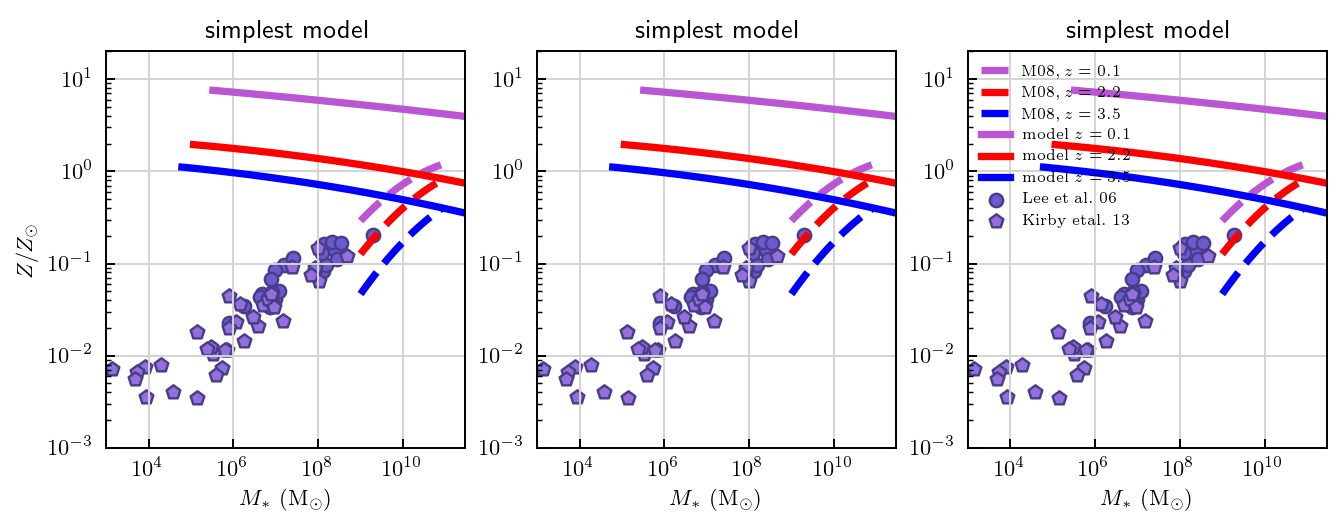

In [36]:
lMsiarr = [lMsnw, lMsnw, lMsnw]; lMZiarr = [lMZnw, lMZnw, lMZnw];
lMgiarr = [lMgnw, lMgnw, lMgnw];

# these titles are passed on to put a title on top of each panel
titles = ['simplest model', 'simplest model', 'simplest model']

# these arrays define at which redshifts to plot model predictions and which colors to use for lines at these z
zplot = [0.07, 2.2, 3.5];  zcolors = ['mediumorchid', 'red', 'blue', 'darkgray']

# plot
plot_MsZ_model_obs(lMsiarr, lMgiarr, lMZiarr,  zplot=zplot, titles=titles)


### Task 2

Compute and plot *effective yield* defined as 
$$y_{\rm eff}=\frac{Z}{\ln(1/f_{\rm g})}\leq y_{\rm Z},\ \ \  \mathrm{where}\ \ \ \ f_{\rm g}=\frac{M_{\rm g}}{M_{\rm g}+M_\star},$$
Effective yield is predicted to be equal to $y_Z= 0.07$ for a system which just has some initial gas, but experiences no no inflows or outflows of gas (see below). Deviations of $y_{\rm eff}$ from $y_Z$ thus indicates presence of inflows and/or outflows. It is especially sensitive to outflows.  Explore $y_{\rm eff}$ predicted by different models as a function of $M_\star+M_{\rm gas}$ or as a function of $M_{\rm gas}$. Compare your results to observational measurements in Figure 11 of <a href="https://ui.adsabs.harvard.edu/abs/2006ApJ...647..970L/abstract">Lee et al. (2006).</a> Examine how value of $y_{\rm eff}$ depends on the value of mass loading factor $\eta$ assumed in the wind model (either models with constant $\eta$ or normalization factor in the models in which $\eta$ depend on $M_\star$. 

### Possible extra exercise:

* explore effect of gas accretion suppression due to UV heating on the $Z-M_\star$ relation in the models with winds by setting up a model with wind where this heating effect is turned off. 

### Closed-box model of evolution for gas metallicity: solution

We have $M_{\star+\rm g}=M_\star+ M_{\rm g}=\mathrm{const}$, so $d\tilde{M}_\star=-dM_{\rm g}$ and so multiplying the evolution equation 

$$
\dot{M}_{\rm Z} = (y_{\rm Z}-Z)\,\dot{\tilde{M}}_{\rm \star}.
$$

by $dt$ and dividing by $d\tilde{M}_\star$ gives

$$\frac{dM_{\rm Z}}{d\tilde{M}_\star} = y_{\rm Z} - Z.$$

$Z=M_{\rm Z}/M_{\rm g}$ so its differential is 

$$dZ = \frac{dM_{\rm Z}}{M_{\rm g}} - Z\frac{dM_{\rm g}}{M_{\rm g}}. $$

Multiplying it by $M_{\rm g}$ and dividing by $d\tilde{M}_\star$ we get 

$$M_{\rm g}\frac{dZ}{d\tilde{M}_{\star}} = -M_{\rm g}\frac{dZ}{dM_{\rm g}} = 
\frac{dM_{\rm Z}}{d\tilde{M}_\star} - Z\frac{dM_{\rm g}}{d\tilde{M}_{\star}} = y_{\rm Z}-Z + Z= y_{\rm Z},$$

where we used equations above in the last step. Thus, we have 

$$dZ = -y_{\rm Z}\frac{dM_{\rm g}}{M_{\rm g}},$$

which, assuming that $y_{\rm Z}=\mathrm{const}$ has the solution

$$Z(t) = Z(t_i) - y_{\rm Z}\left[\ln M_{\rm g}(t) - \ln M_{\rm g}(t_i)\right] = Z(t_i) + y_{\rm Z}\ln \left(\frac{1}{f_{\rm g}}\right), $$

where $Z(t_i)$ and $M_{\rm g}(t_i)$ are the initial metallicity and gas mass at some initial time $t_i$. If we start before any star formation $Z(t_i)=0$ and $M_{\rm g}(t_i) = M_{\star +\rm g}=\mathrm{const}$ (it's closed box!), so the ratio of final to the initial gas mass is equal to the fraction of mass in gas at any time: $M_{\rm g}(t)/M_{\rm g}(t_i) = M_{\rm g}(t)/[M_{\rm g}(t)+M_\star(t)]=f_{\rm g}(t).$

$$Z(t) = y_{\rm Z}\ln \left(\frac{1}{f_{\rm g}}\right), $$
